In [125]:
!rm -rf *.png out.zip

In [126]:
opt_name = "sgd"

#Fold vs Prune and Ablations

In [127]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import colormaps
from pathlib import Path
import seaborn as sns

In [128]:
# Load text content
with open(f"{opt_name}-fold", "r") as f:
    fold_text = f.read()
with open(f"{opt_name}-mag-l1", "r") as f:
    mag1_text = f.read()
with open(f"{opt_name}-mag-l2", "r") as f:
    mag2_text = f.read()

In [129]:
def extract_data(text, include=None, exclude=None, keep_extra=False):
    """
    Parse log `text` into a DataFrame with rows for BASE (sparsity=0.0) and PRUNE/REPAIR pairs.
    Supports filtering by base_acc (acc_before), lr, l1, wd, augmentations (rand_aug), and sam.

    Columns (at least): model_id | model | sparsity | acc_before | acc_after | l1 | wd | lr | rand_aug | sam
    """
    import re, pandas as pd

    rows = []
    block_re = re.compile(r"\[MODEL\]\s+(\d+)/\d+\s+(.*?)\.pth(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)

    def tok(name, key, default=None):
        # match tokens like ..._key=VALUE_... (VALUE may be number or True/False)
        m = re.search(rf"(?:^|[_-]){key}=([A-Za-z0-9+.\-eE]+|True|False)(?=[_-]|$)", name)
        if not m: return default
        v = m.group(1)
        vl = v.lower()
        if vl in ("true","false"): return vl == "true"
        try:
            if re.fullmatch(r"[+-]?\d+", v): return int(v)
            return float(v)
        except:
            return v

    # keys we care about (add more if needed)
    keys = ("lr","l1","wd","rand_aug","sam","sam_rho","lr_schedule","opt","dataset","arch","seed","batch_size","epochs","momentum")

    for mid, name, block in block_re.findall(text):
        mid = int(mid)
        kv = {k: tok(name, k) for k in keys}

        base = re.search(r"RATIO=0\.0\s+EVENT=BASE\s+params=(\d+)\s+acc=([0-9.]+)", block)
        if not base:
            continue
        base_params, base_acc = int(base.group(1)), float(base.group(2))

        # BASE row (sparsity 0.0)
        base_row = dict(model_id=mid, model=name, sparsity=0.0,
                        acc_before=base_acc, acc_after=base_acc, **kv if keep_extra else {})
        # always keep these common hparams even if keep_extra=False
        for k in ("l1","wd","lr","rand_aug","sam"):
            base_row[k] = kv.get(k)
        rows.append(base_row)

        # PRUNE/REPAIR pairs (match by ratio)
        prunes  = {float(r):(int(p), float(a)) for r,p,a in re.findall(
            r"RATIO=([0-9.]+)\s+EVENT=PRUNE\s+params=(\d+)\s+acc=([0-9.]+)", block)}
        repairs = {float(r):float(a) for r,a in re.findall(
            r"RATIO=([0-9.]+)\s+EVENT=REPAIR\s+acc=([0-9.]+)", block)}
        for r in sorted(set(prunes) & set(repairs)):
            pruned_params, _ = prunes[r]
            sparsity = 1.0 - pruned_params / base_params
            row = dict(model_id=mid, model=name, sparsity=sparsity, ratio=float(r),
                       acc_before=base_acc, acc_after=repairs[r], **kv if keep_extra else {})
            for k in ("l1","wd","lr","rand_aug","sam"):
                row[k] = kv.get(k)
            rows.append(row)

    df = pd.DataFrame(rows)
    if df.empty: return df

    # Normalize dtypes for filtering
    for col in ("wd","l1","lr","acc_before","acc_after","sparsity"):
        if col in df: df[col] = pd.to_numeric(df[col], errors="coerce")
    for col in ("rand_aug","sam"):
        if col in df: df[col] = df[col].astype("boolean")

    # alias map so include/exclude can use intuitive names
    alias = {"base_acc": "acc_before", "augmentations": "rand_aug", "aug": "rand_aug"}
    def _col(k): return alias.get(k, k)

    # filtering
    def _match(s, cond):
        if callable(cond): return s.map(cond).fillna(False)
        if isinstance(cond, (list, tuple, set)): return s.isin(cond)
        return s == cond

    if include:
        m = pd.Series(True, index=df.index)
        for k, c in include.items():
            col = _col(k)
            if col in df: m &= _match(df[col], c)
        df = df[m]
    if exclude:
        m = pd.Series(False, index=df.index)
        for k, c in exclude.items():
            col = _col(k)
            if col in df: m |= _match(df[col], c)
        df = df[~m]

    return df.reset_index(drop=True)


In [130]:
# --- Extract ---
# fold_df  = extract_data(fold_text).rename(columns={"acc_after": "acc_fold"})
# mag_l1_df = extract_data(mag1_text).rename(columns={"acc_after": "acc"})
# mag_l2_df = extract_data(mag2_text).rename(columns={"acc_after": "acc"})

# --- Extract (exclude wd>0.0 by including only wd==0.0) ---
# fold_df  = extract_data(fold_text,  include={"wd": 0.0, "l1": 0.0})
# mag1_df = extract_data(mag1_text, include={"wd": 0.0, "l1": 0.0})
# mag2_df = extract_data(mag2_text, include={"wd": 0.0, "l1": 0.0})

# thr = 90.0
# fold_df  = extract_data(fold_text,  include={"wd": 0.0, "base_acc": lambda x: pd.notna(x) and x > thr}).rename(columns={"acc_after": "acc_fold"})
# mag_l1_df = extract_data(mag1_text,  include={"wd": 0.0, "base_acc": lambda x: pd.notna(x) and x > thr}).rename(columns={"acc_after": "acc"})
# mag_l2_df = extract_data(mag2_text, include={"wd": 0.0, "base_acc": lambda x: pd.notna(x) and x > thr}).rename(columns={"acc_after": "acc"})

# print(len(fold_df), len(mag1_df), len(mag2_df))

2710 2710 2710


/tmp/ipython-input-4040624735.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


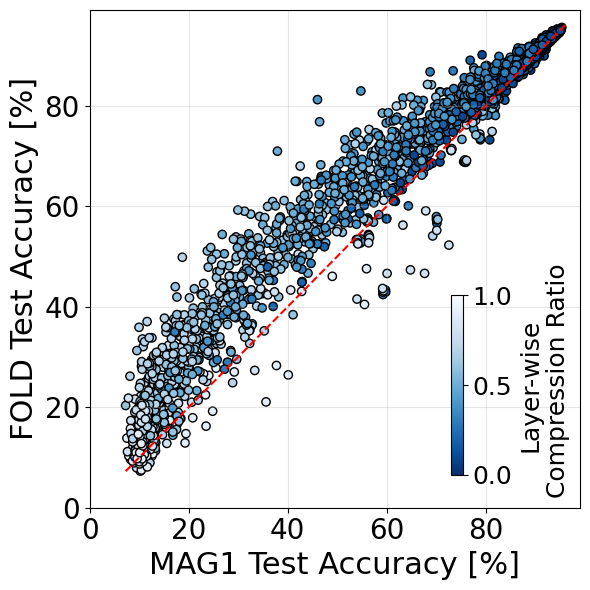

/tmp/ipython-input-4040624735.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


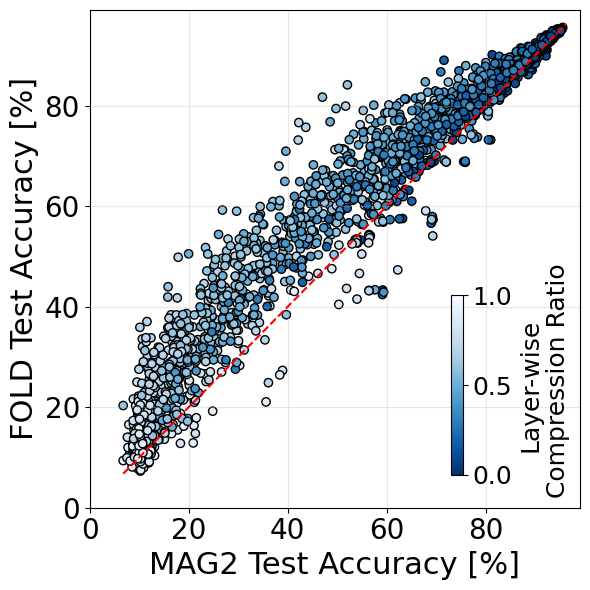

In [131]:
def plot_compration_ratio_scatter(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})
    # Reduce and merge
    x_df = x_df[["model_id","model","ratio","acc_x"]]
    y_df = y_df[["model_id","model","ratio","acc_y"]]

    merged = pd.merge(y_df, x_df, on=["model_id","model","ratio"])
    norm = plt.Normalize(0.0, 1.0)   # full [0,1] range
    cmap = cm.Blues_r

    fig, ax = plt.subplots(figsize=(6,6))
    sc = ax.scatter(
        merged["acc_x"], merged["acc_y"],
        c=merged["ratio"], cmap=cmap, norm=norm,
        marker="o", edgecolor="black"
    )

    lo, hi = merged[["acc_x","acc_y"]].min().min(), merged[["acc_x","acc_y"]].max().max()
    ax.plot([lo,hi],[lo,hi],"r--",label="y = x")

    ax.set_xlabel(f"{x_name} Test Accuracy [%]", fontsize=22)
    ax.set_ylabel(f"{y_name} Test Accuracy [%]", fontsize=22)
    ax.tick_params(axis="both", labelsize=20)
    ax.set_xlim(0, 99)
    ax.set_ylim(0, 99)
    # ax.legend(fontsize=18)
    ax.grid(True, alpha=0.3)

    cbar_ax = fig.add_axes([0.76, 0.20, 0.02, 0.3])
    smap = cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(smap, cax=cbar_ax, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
    cbar.ax.tick_params(labelsize=18)

    fig.tight_layout()
    fig.savefig(f"{opt_name}__compression_ratio_scatter__{x_name}_vs_{y_name}.png", dpi=100)
    plt.show()


# --- Extract (exclude wd>0.0 by including only wd==0.0) ---
# fold_df  = extract_data(fold_text,  include={"wd": 0.0, "l1": 0.0})
# mag1_df = extract_data(mag1_text, include={"wd": 0.0, "l1": 0.0})
# mag2_df = extract_data(mag2_text, include={"wd": 0.0, "l1": 0.0})
fold_df  = extract_data(fold_text,  include={"l1": 0.0})
mag1_df = extract_data(mag1_text, include={"l1": 0.0})
mag2_df = extract_data(mag2_text, include={"l1": 0.0})

# Print
print(len(fold_df), len(mag1_df), len(mag2_df))

plot_compration_ratio_scatter(mag1_df, fold_df, "MAG1", "FOLD")
plot_compration_ratio_scatter(mag2_df, fold_df, "MAG2", "FOLD")

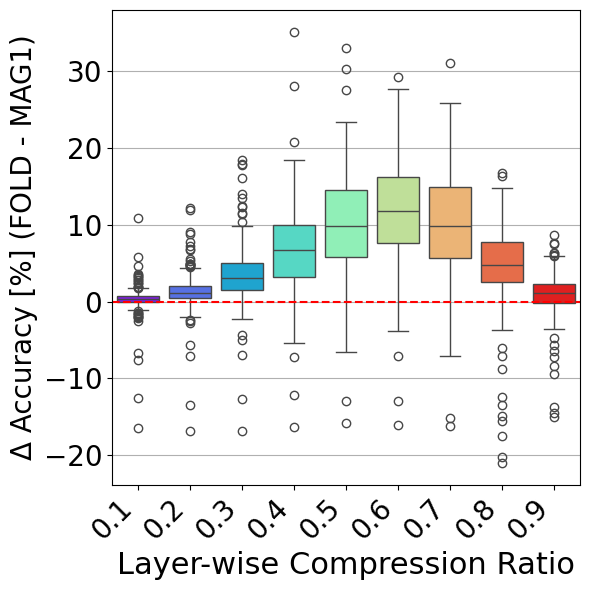

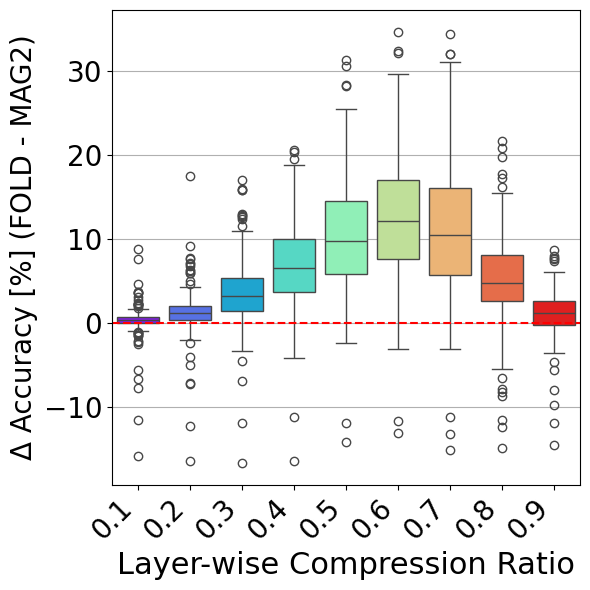

In [132]:
def plot_compration_ratio_hist(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})
    # Merge
    merged_df = pd.merge(y_df[["model", "ratio", "acc_y"]], x_df[["model", "ratio", "acc_x"]], on=["model", "ratio"])

    # Compute relative difference
    merged_df["diff"] = merged_df["acc_y"] - merged_df["acc_x"]
    boxplot_df = merged_df[["ratio", "diff"]].copy()

    # Get sorted unique sparsities
    unique_sparsities = sorted(boxplot_df["ratio"].unique())
    cmap = colormaps["Blues_r"]
    palette = [cmap(0.3 + 0.6 * i / max(len(unique_sparsities) - 1, 1)) for i in range(len(unique_sparsities))]
    palette_dict = dict(zip(unique_sparsities, palette))

    # Plotting with increased font sizes
    fig = plt.figure(figsize=(6, 6))
    sns.boxplot(
        data=boxplot_df,
        x="ratio",
        y="diff",
        hue="ratio",
        palette="rainbow",
        dodge=False,
        legend=False
    )

    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Layer-wise Compression Ratio", fontsize=22)
    plt.ylabel(f"Δ Accuracy [%] ({y_name} - {x_name})", fontsize=20)

    plt.xticks(rotation=45, ha="right", fontsize=20)
    plt.yticks(fontsize=20)

    plt.grid(True, axis='y')
    # plt.ylim(-30, 40)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__compression_ratio_hist__{x_name}_vs_{y_name}.png", dpi=100)


plot_compration_ratio_hist(mag1_df, fold_df, "MAG1", "FOLD")
plot_compration_ratio_hist(mag2_df, fold_df, "MAG2", "FOLD")

In [133]:
def format_lr_label(lr, tol=1e-12):
    if lr is None or np.isnan(lr) or lr <= 0:
        return "LR=?"
    # power-of-ten?
    exp_rounded = int(round(np.log10(lr)))
    if np.isclose(lr, 10**exp_rounded, rtol=0, atol=tol):
        return rf"LR=$10^{{{exp_rounded}}}$"
    # general scientific form m × 10^n
    exp = int(np.floor(np.log10(lr)))
    mant = lr / (10**exp)
    mant_str = f"{mant:.0f}" if np.isclose(mant, round(mant), atol=tol) else f"{mant:.2g}"
    return rf"LR=${mant_str}\times 10^{{{exp}}}$"

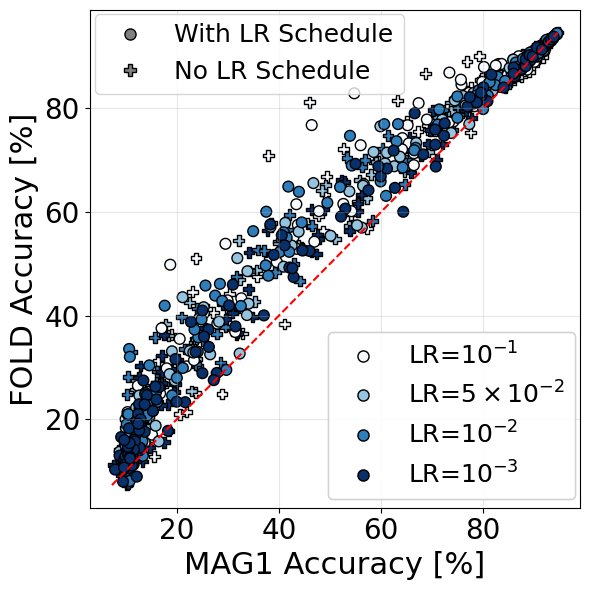

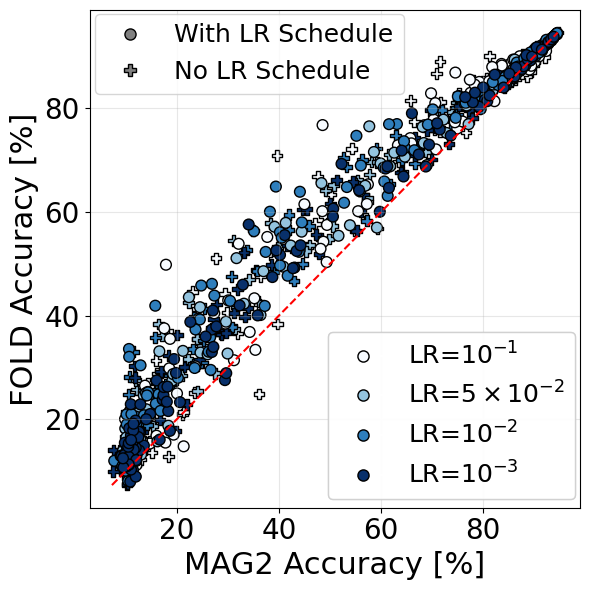

In [134]:
def plot_lr_scatter(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})

    if opt_name == "adam":
        lr_levels = [0.1, 0.01, 0.001]
        colors = cm.Blues_r([1.0, 0.3, 0.0])
    else:  # SGD
        lr_levels = [0.1, 0.05, 0.01, 0.001]
        colors = cm.Blues_r([1.0, 0.6, 0.3, 0.0])

    lr_to_color = dict(zip(lr_levels, colors))
    schedule_to_marker = {True: 'o', False: 'P'}
    marker_labels = {True: "With LR Schedule", False: "No LR Schedule"}

    def canon_lr(x):
        if pd.isna(x): return np.nan
        return min(lr_levels, key=lambda l: abs(float(x) - l))

    merged = pd.merge(
        y_df[["model","ratio","acc_y"]],
        x_df [["model","ratio","acc_x"]],
        on=["model","ratio"], how="inner"
    )

    # extract hparams from model string (robust)
    to_num = lambda s: pd.to_numeric(s, errors="coerce")
    merged["l1"] = to_num(merged["model"].str.extract(r"l1=([0-9.eE+-]+)", expand=False))
    merged["lr"] = to_num(merged["model"].str.extract(r"lr=([0-9.eE+-]+)", expand=False))
    merged["wd"] = to_num(merged["model"].str.extract(r"wd=([0-9.eE+-]+)", expand=False)).fillna(0.0)
    merged["lr_schedule"] = merged["model"].str.extract(r"lr_schedule=(True|False)", expand=False)\
                                              .map({"True": True, "False": False})

    # filter
    subset = merged[merged["l1"].isin([0.0]) & np.isclose(merged["wd"], 0.0)].copy()

    # canonicalize lr for color mapping
    subset["lr_canon"] = subset["lr"].map(canon_lr)
    subset = subset.dropna(subset=["lr_canon"])
    subset["color"] = subset["lr_canon"].map(lr_to_color)

    # plot
    fig, ax = plt.subplots(figsize=(6, 6), sharex=True)
    df = subset

    for sched, g in df.groupby("lr_schedule", dropna=False):
        ax.scatter(g["acc_x"], g["acc_y"], c=g["color"].tolist(),
                   marker=schedule_to_marker.get(bool(sched), 'o'),
                   edgecolor="black", s=60)

    lo = min(df["acc_x"].min(), df["acc_y"].min())
    hi = max(df["acc_x"].max(), df["acc_y"].max())
    ax.plot([lo, hi], [lo, hi], "r--")

    ax.set_xlabel(f"{x_name} Accuracy [%]", fontsize=22)
    ax.set_ylabel(f"{y_name} Accuracy [%]", fontsize=22)
    ax.tick_params(axis="both", labelsize=20)
    ax.grid(True, alpha=0.3)

    # Legends
    color_handles = [
            plt.Line2D([0],[0], marker='o', color='w', label=format_lr_label(lr),
                      markerfacecolor=lr_to_color[lr], markeredgecolor='black', markersize=8)
            for lr in lr_levels
        ]
    marker_handles = [
            plt.Line2D([0],[0], marker=m, color='grey', label=label,
                      markerfacecolor='grey', markeredgecolor='black', linestyle='None', markersize=8)
            for val, m in schedule_to_marker.items()
            for label in [marker_labels[val]]
        ]
    leg1 = fig.legend(handles=color_handles, loc="lower right", bbox_to_anchor=(0.988, 0.14), fontsize=18)
    leg2 = fig.legend(handles=marker_handles, loc="upper left", bbox_to_anchor=(0.145, 0.99), fontsize=18)
    plt.gca().add_artist(leg1)

    plt.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__lr_scatter__{x_name}_vs_{y_name}.png", dpi=100)


plot_lr_scatter(mag1_df, fold_df, "MAG1", "FOLD")
plot_lr_scatter(mag2_df, fold_df, "MAG2", "FOLD")

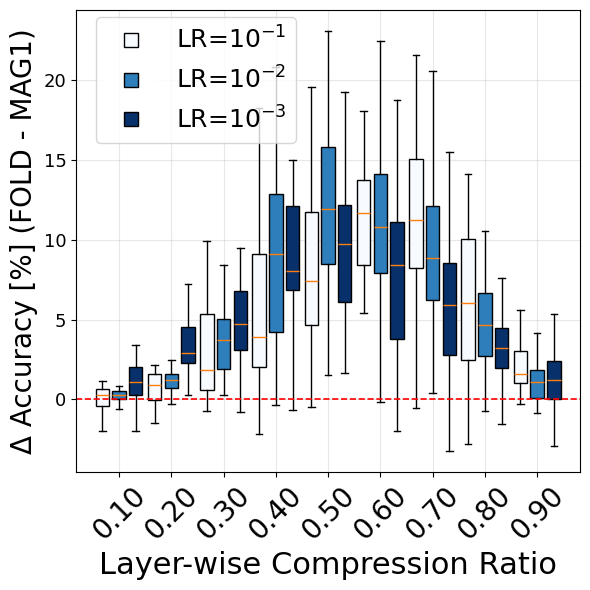

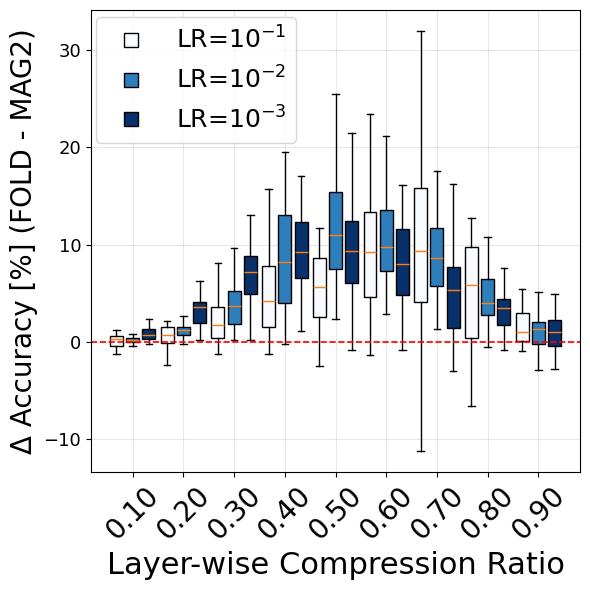

In [135]:
def plot_fold_vs_method_box_by_ratio_lr(x_df, y_df, x_name, y_name):
    if opt_name == "adam":
        lr_levels = [0.1, 0.01, 0.001]
        colors = cm.Blues_r([1.0, 0.3, 0.0])
    else: # SGD
        # lr_levels = [0.1, 0.05, 0.01, 0.001]
        # colors = cm.Blues_r([1.0, 0.6, 0.3, 0.0])
        lr_levels = [0.1, 0.01, 0.001]
        colors = cm.Blues_r([1.0, 0.3, 0.0])

    lr_to_color = dict(zip(lr_levels, colors))
    schedule_to_marker = {True: 'o', False: 'P'}
    marker_labels = {True: "With LR Schedule", False: "No LR Schedule"}

    def canon_lr(x):
        if pd.isna(x): return np.nan
        return min(lr_levels, key=lambda l: abs(float(x) - l))

    def grouped_positions(x_vals, n_groups, width=0.18):
        offsets = np.linspace(-((n_groups-1)/2)*width, ((n_groups-1)/2)*width, n_groups)
        return {gi: (np.asarray(x_vals) + offsets[gi]) for gi in range(n_groups)}, width

    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})

    merged = pd.merge(
        y_df[["model","ratio","acc_y"]],
        x_df[["model","ratio","acc_x"]],
        on=["model","ratio"], how="inner"
    )

    to_num = lambda s: pd.to_numeric(s, errors="coerce")
    merged["l1"] = to_num(merged["model"].str.extract(r"l1=([0-9.eE+-]+)", expand=False))
    merged["lr"] = to_num(merged["model"].str.extract(r"lr=([0-9.eE+-]+)", expand=False))
    merged["wd"] = to_num(merged["model"].str.extract(r"wd=([0-9.eE+-]+)", expand=False)).fillna(0.0)
    merged["lr_schedule"] = merged["model"].str.extract(r"lr_schedule=(True|False)", expand=False)\
                                              .map({"True": True, "False": False})

    subset = merged[merged["l1"].isin([0.0]) & np.isclose(merged["wd"], 0.0)].copy()
    subset["lr_canon"] = subset["lr"].map(canon_lr)
    subset = subset.dropna(subset=["lr_canon"]).copy()
    subset["color"] = subset["lr_canon"].map(lr_to_color)
    subset["diff"] = subset["acc_y"] - subset["acc_x"]

    fig, ax = plt.subplots(figsize=(6, 6))
    all_ratios = sorted(subset["ratio"].unique())
    all_ratios = all_ratios[1:]


    df = subset
    x = np.arange(len(all_ratios), dtype=float)
    n_groups = len(lr_levels)
    pos_map, box_w = grouped_positions(x, n_groups, width=0.32)

    # boxplots per (ratio, lr)
    for gi, lr in enumerate(lr_levels):
        pos = pos_map[gi]
        data_for_boxes = []
        valid_pos = []
        for r_i, r in enumerate(all_ratios):
            vals = df[(df["ratio"] == r) & (df["lr_canon"] == lr)]["diff"].tolist()
            if vals:
                data_for_boxes.append(vals)
                valid_pos.append(pos[r_i])
        if data_for_boxes:
            bp = ax.boxplot(
                data_for_boxes,
                positions=valid_pos,
                widths=box_w*0.8,
                patch_artist=True,
                showfliers=False
                )
            for patch in bp["boxes"]:
                patch.set(facecolor=lr_to_color[lr], alpha=1.0, edgecolor="black")

    # aesthetics
    ax.set_xlabel("Layer-wise Compression Ratio", fontsize=22)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{r:.2f}" if isinstance(r, float) else str(r) for r in all_ratios], rotation=45, fontsize=20)
    ax.axhline(0.0, color="red", linestyle="--", linewidth=1.2)  # accuracy gain = 0 line
    ax.tick_params(axis="y", labelsize=13)
    ax.grid(True, alpha=0.3)

    ax.set_ylabel(f"Δ Accuracy [%] ({y_name} - {x_name})", fontsize=20)

    # Legends
    color_handles = [
        plt.Line2D([0],[0], marker='s', color='w', label=format_lr_label(lr),
                   markerfacecolor=lr_to_color[lr], markeredgecolor='black', markersize=10)
        for lr in lr_levels
        ]
    leg1 = fig.legend(handles=color_handles, loc="upper left", bbox_to_anchor=(0.147, 0.985), fontsize=18)

    plt.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__lr_hist__{x_name}_vs_{y_name}.png", dpi=100)


plot_fold_vs_method_box_by_ratio_lr(mag1_df, fold_df, "MAG1", "FOLD")
plot_fold_vs_method_box_by_ratio_lr(mag2_df, fold_df, "MAG2", "FOLD")

/tmp/ipython-input-221903395.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


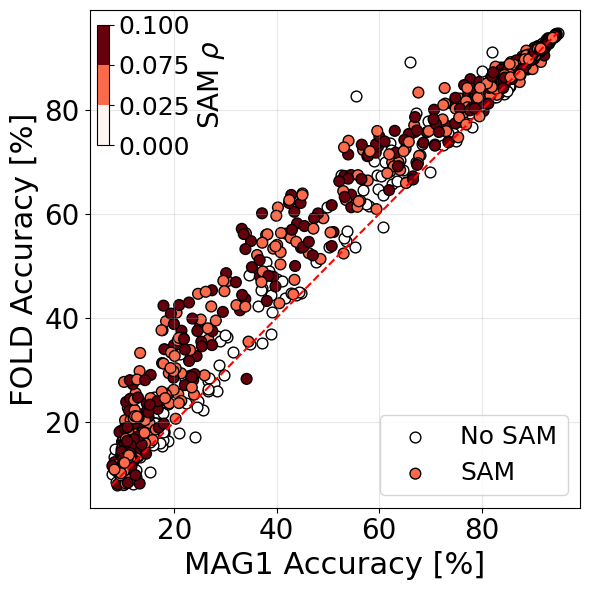

/tmp/ipython-input-221903395.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


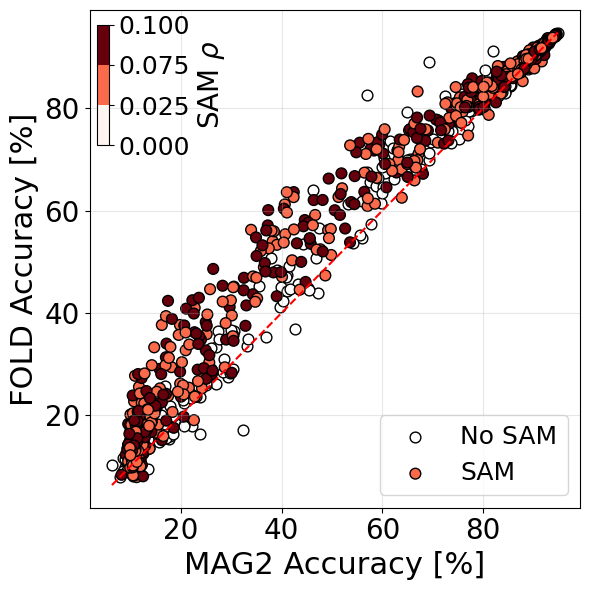

/tmp/ipython-input-221903395.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


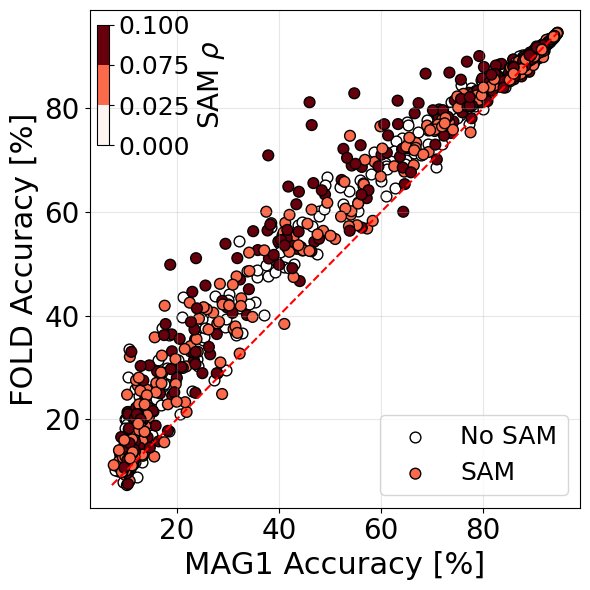

/tmp/ipython-input-221903395.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


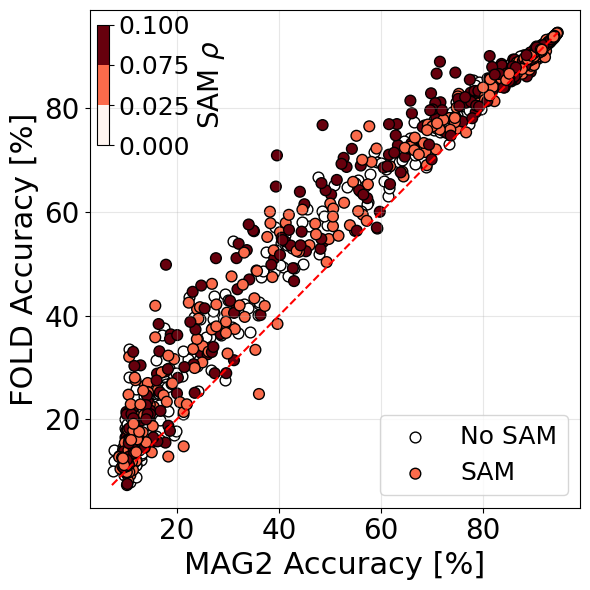

In [136]:
def plot_sam_scatter(x_df, y_df, x_name, y_name, l1_target):
    # --- FOLD vs MAG colored by SAM ρ (WD==0 only), split by L1 ---
    rho_bins = np.array([0.0, 0.025, 0.075, 0.10])  # bin edges for colorbar
    norm = mcolors.BoundaryNorm(boundaries=rho_bins, ncolors=256)
    cmap = cm.Reds

    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})

    # merge on sure keys
    merged = pd.merge(
        y_df[["model","ratio","acc_y"]],
        x_df[["model","ratio","acc_x"]],
        on=["model","ratio"], how="inner"
    )

    to_num = lambda s: pd.to_numeric(s, errors="coerce")

    # extract hparams from model name (fill sensible defaults)
    merged["l1"]  = to_num(merged["model"].str.extract(r"l1=([0-9.eE+-]+)", expand=False))
    merged["wd"]  = to_num(merged["model"].str.extract(r"wd=([0-9.eE+-]+)", expand=False)).fillna(0.0)
    merged["sam"] = merged["model"].str.extract(r"sam=(True|False)", expand=False).map({"True": True, "False": False}).fillna(False)
    merged["sam_rho"] = to_num(merged["model"].str.extract(r"sam_rho=([0-9.eE+-]+)", expand=False)).fillna(0.0)
    merged.loc[~merged["sam"], "sam_rho"] = 0.0  # force ρ=0 when SAM=False
    merged["raug"] = merged["model"].str.extract(r"(?i)rand_aug=(True|False)", expand=False).map({"True": True, "False": False}).fillna(False)

    # filter
    subset = merged[np.isclose(merged["wd"], 0.0) & merged["l1"].isin([l1_target])].copy()

    fig, ax = plt.subplots(figsize=(6, 6))
    df = subset

    # No SAM (white)
    ns = df[df["sam_rho"] == 0.0]
    if not ns.empty:
        ax.scatter(ns["acc_x"], ns["acc_y"], c="white", edgecolor="black", s=60, label="No SAM")

    # SAM colored by ρ
    sm = df[df["sam_rho"] > 0.0]
    if not sm.empty:
        sc = ax.scatter(sm["acc_x"], sm["acc_y"], c=sm["sam_rho"], cmap=cmap, norm=norm,
                        edgecolor="black", s=60, label="SAM")

    # y = x
    lo = df[["acc_x","acc_y"]].min().min()
    hi = df[["acc_x","acc_y"]].max().max()
    ax.plot([lo, hi], [lo, hi], "r--")

    ax.set_xlabel(f"{x_name} Accuracy [%]", fontsize=22)
    ax.set_ylabel(f"{y_name} Accuracy [%]", fontsize=22)
    ax.tick_params(axis="both", labelsize=20)
    ax.legend(fontsize=18, loc="lower right")
    ax.grid(True, alpha=0.3)

    # shared colorbar (only meaningful if SAM points exist)
    if (subset["sam_rho"] > 0).any():
        cbar_ax = fig.add_axes([0.17, 0.75, 0.02, 0.2])
        smap = cm.ScalarMappable(norm=norm, cmap=cmap)
        cbar = fig.colorbar(smap, cax=cbar_ax, ax=ax, fraction=0.035, pad=0.02)
        cbar.set_label(r"SAM $\rho$", fontsize=20)
        cbar.set_ticks(rho_bins)
        cbar.set_ticklabels([f"{b:.3f}" for b in rho_bins])
        cbar.ax.tick_params(labelsize=18)

    fig.tight_layout()
    fig.savefig(f"{opt_name}__sam_scatter__{x_name}_vs_{y_name}_l1_{l1_target}.png", dpi=100)
    plt.show()


fold_df  = extract_data(fold_text, include={"l1": 1e-5})
mag1_df = extract_data(mag1_text, include={"l1": 1e-5})
mag2_df = extract_data(mag2_text, include={"l1": 1e-5})

plot_sam_scatter(mag1_df, fold_df, "MAG1", "FOLD", l1_target=1e-5)
plot_sam_scatter(mag2_df, fold_df, "MAG2", "FOLD", l1_target=1e-5)

fold_df  = extract_data(fold_text, include={"l1": 0.0})
mag1_df = extract_data(mag1_text, include={"l1": 0.0})
mag2_df = extract_data(mag2_text, include={"l1": 0.0})

plot_sam_scatter(mag1_df, fold_df, "MAG1", "FOLD", l1_target=0.0)
plot_sam_scatter(mag2_df, fold_df, "MAG2", "FOLD", l1_target=0.0)


/tmp/ipython-input-2159481418.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


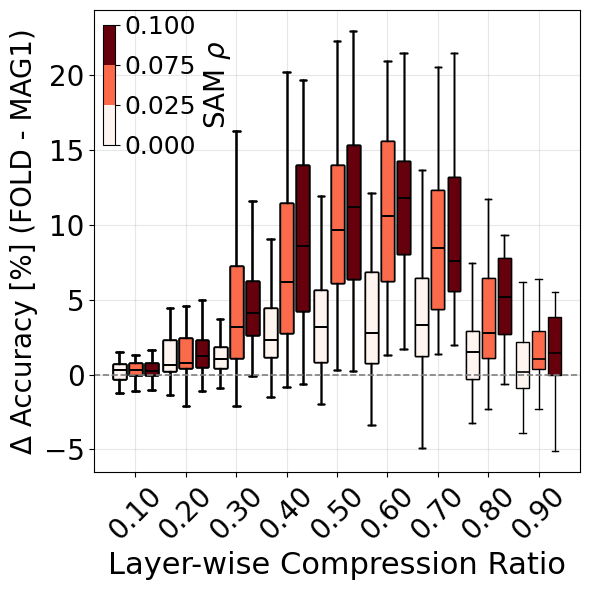

/tmp/ipython-input-2159481418.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


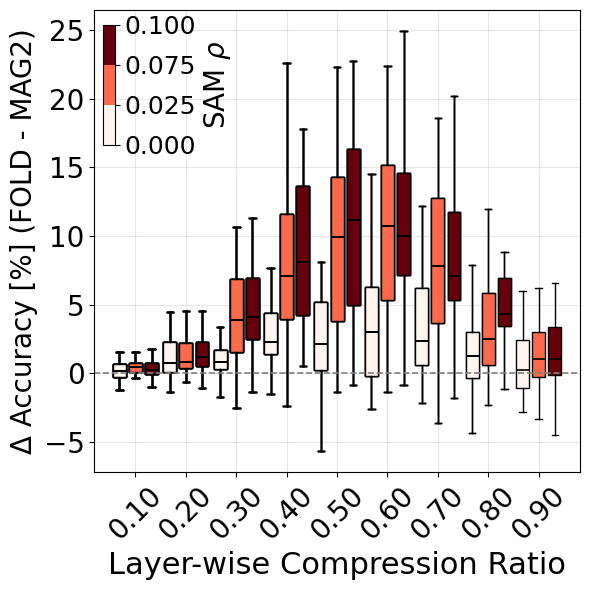

/tmp/ipython-input-2159481418.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


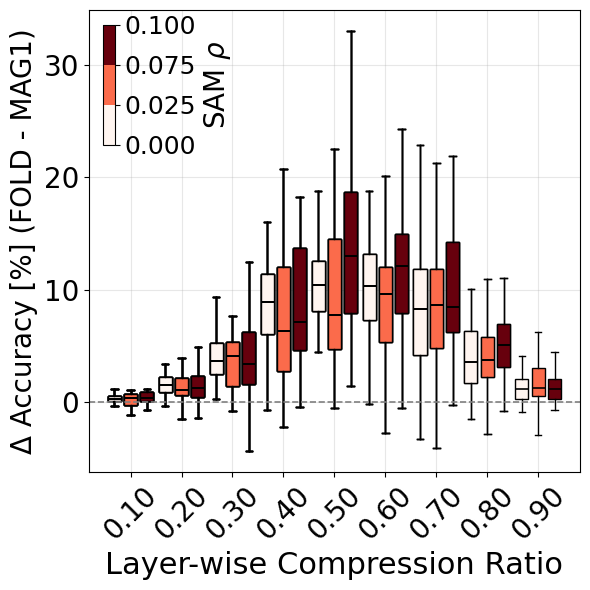

/tmp/ipython-input-2159481418.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


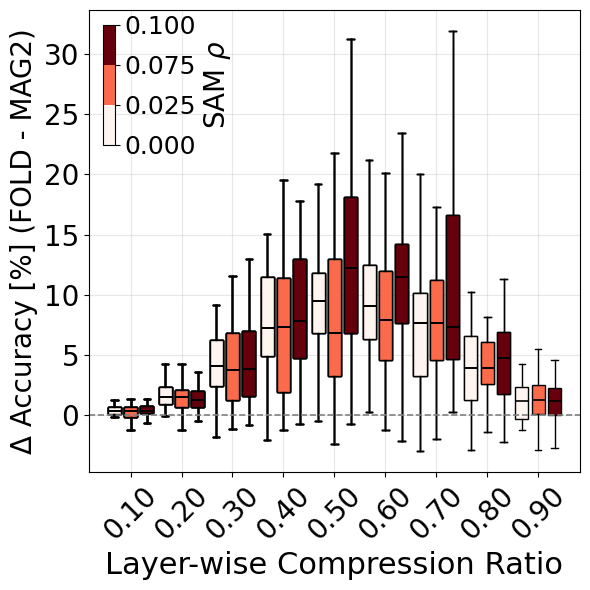

In [137]:
def plot_sam_hist(x_df, y_df, x_name, y_name, l1_target=0.0):
    # --- config for SAM ρ binning & colors ---
    rho_bins = np.array([0.0, 0.025, 0.075, 0.10])  # [0, 0.025), [0.025, 0.075), [0.075, 0.10]
    norm = mcolors.BoundaryNorm(boundaries=rho_bins, ncolors=256)
    cmap = cm.Reds

    def rho_bin_label(low, high):
        # closed on left, open on right except final bin which is closed-closed for labeling clarity
        if high == rho_bins[-1]:
            return f"[{low:.3f}, {high:.3f}]"
        return f"[{low:.3f}, {high:.3f})"

    # helper for grouped positions (group = rho-bin within each ratio)
    def grouped_positions(x_vals, n_groups, width=0.20):
        offsets = np.linspace(-((n_groups-1)/2)*width, ((n_groups-1)/2)*width, n_groups)
        return {gi: (np.asarray(x_vals) + offsets[gi]) for gi in range(n_groups)}, width

    # Precompute discrete bin colors and labels
    bin_edges = list(zip(rho_bins[:-1], rho_bins[1:]))
    bin_labels = [rho_bin_label(a, b) for a, b in bin_edges]
    # sample the colormap at bin midpoints for consistent box colors
    bin_mids = [(a + b) / 2.0 for a, b in bin_edges]
    bin_colors = [cmap(norm(m)) for m in bin_mids]

    # Map ρ to bin index (-1 for exactly 0 with no SAM when bins start at 0.0; we still place it in first bin)
    def rho_to_bin_idx(r):
        # Put r=0 into the first bin [0,0.025)
        if r <= rho_bins[1] and r >= rho_bins[0]:
            return 0
        for i, (a, b) in enumerate(bin_edges):
            if (r >= a) and (r < b):
                return i
        # if equals last edge, place into last bin
        if np.isclose(r, rho_bins[-1]):
            return len(bin_edges) - 1
        return None

    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})

    # merge on sure keys
    merged = pd.merge(
        y_df[["model","ratio","acc_y"]],
        x_df[["model","ratio","acc_x"]],
        on=["model","ratio"], how="inner"
        )

    to_num = lambda s: pd.to_numeric(s, errors="coerce")

    # extract hparams from model name (fill sensible defaults)
    merged["l1"]  = to_num(merged["model"].str.extract(r"l1=([0-9.eE+-]+)", expand=False))
    merged["wd"]  = to_num(merged["model"].str.extract(r"wd=([0-9.eE+-]+)", expand=False)).fillna(0.0)
    merged["sam"] = merged["model"].str.extract(r"sam=(True|False)", expand=False)\
                        .map({"True": True, "False": False}).fillna(False)
    merged["sam_rho"] = to_num(merged["model"].str.extract(r"sam_rho=([0-9.eE+-]+)", expand=False)).fillna(0.0)
    merged.loc[~merged["sam"], "sam_rho"] = 0.0  # force ρ=0 when SAM=False
    merged["raug"] = merged["model"].str.extract(r"(?i)rand_aug=(True|False)", expand=False)\
                          .map({"True": True, "False": False}).fillna(False)

    # filter
    subset = merged[np.isclose(merged["wd"], 0.0) & merged["l1"].isin([l1_target])].copy()

    # Δ accuracy = FOLD − method
    subset["diff"] = subset["acc_y"] - subset["acc_x"]

    # Determine available ratios and valid rho-bin groups present in data
    all_ratios = sorted(subset["ratio"].unique())
    all_ratios = all_ratios[1:]

    fig, ax = plt.subplots(figsize=(6, 6))

    df = subset

    x = np.arange(len(all_ratios), dtype=float)
    n_groups = len(bin_edges)
    pos_map, box_w = grouped_positions(x, n_groups, width=0.32)

    # Build and draw boxplots per (ratio, rho-bin)
    for gi, (a, b) in enumerate(bin_edges):
        pos = pos_map[gi]
        data_for_boxes, valid_pos = [], []
        for r_i, r in enumerate(all_ratios):
            vals = df[(df["ratio"] == r) &
            (df["sam_rho"] >= a) &
            (df["sam_rho"] <  b if b < rho_bins[-1] else df["sam_rho"] <= b)
            ]["diff"].tolist()
            if vals:
                data_for_boxes.append(vals)
                valid_pos.append(pos[r_i])
            if data_for_boxes:
                bp = ax.boxplot(
                    data_for_boxes,
                    positions=valid_pos,
                    widths=box_w*0.8,
                    patch_artist=True,
                    showfliers=False
                    )
            # style
            for patch in bp["boxes"]:
                patch.set(facecolor=bin_colors[gi], alpha=1.0, edgecolor="black")
            for whisk in bp["whiskers"]:
                whisk.set(color="black", linewidth=1)
            for cap in bp["caps"]:
                cap.set(color="black", linewidth=1)
            for median in bp["medians"]:
                median.set(color="black", linewidth=1.2)

    # aesthetics
    ax.set_xlabel("Layer-wise Compression Ratio", fontsize=22)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{r:.2f}" if isinstance(r, float) else str(r) for r in all_ratios], rotation=45, fontsize=20)
    ax.axhline(0.0, color="gray", linestyle="--", linewidth=1.2)  # accuracy gain = 0
    ax.tick_params(axis="y", labelsize=20)
    ax.grid(True, alpha=0.3)

    ax.set_ylabel(f"Δ Accuracy [%] ({y_name} - {x_name})", fontsize=20)

    if (subset["sam_rho"] > 0).any():
        # cbar_ax = fig.add_axes([0.21, 0.75, 0.02, 0.2])
        cbar_ax = fig.add_axes([0.18, 0.75, 0.02, 0.2])
        smap = cm.ScalarMappable(norm=norm, cmap=cmap)
        cbar = fig.colorbar(smap, cax=cbar_ax, ax=ax, fraction=0.035, pad=0.02)
        cbar.set_label(r"SAM $\rho$", fontsize=20)
        cbar.set_ticks(rho_bins)
        cbar.set_ticklabels([f"{b:.3f}" for b in rho_bins])
        cbar.ax.tick_params(labelsize=18)

    plt.tight_layout()
    fig.savefig(f"{opt_name}__sam_hist__{x_name}_vs_{y_name}_l1_{l1_target}.png", dpi=100)
    plt.show()


fold_df  = extract_data(fold_text, include={"l1": 1e-5})
mag1_df = extract_data(mag1_text, include={"l1": 1e-5})
mag2_df = extract_data(mag2_text, include={"l1": 1e-5})

plot_sam_hist(mag1_df, fold_df, "MAG1", "FOLD", l1_target=1e-5)
plot_sam_hist(mag2_df, fold_df, "MAG2", "FOLD", l1_target=1e-5)

fold_df  = extract_data(fold_text, include={"l1": 0.0})
mag1_df = extract_data(mag1_text, include={"l1": 0.0})
mag2_df = extract_data(mag2_text, include={"l1": 0.0})

plot_sam_hist(mag1_df, fold_df, "MAG1", "FOLD", l1_target=0.0)
plot_sam_hist(mag2_df, fold_df, "MAG2", "FOLD", l1_target=0.0)


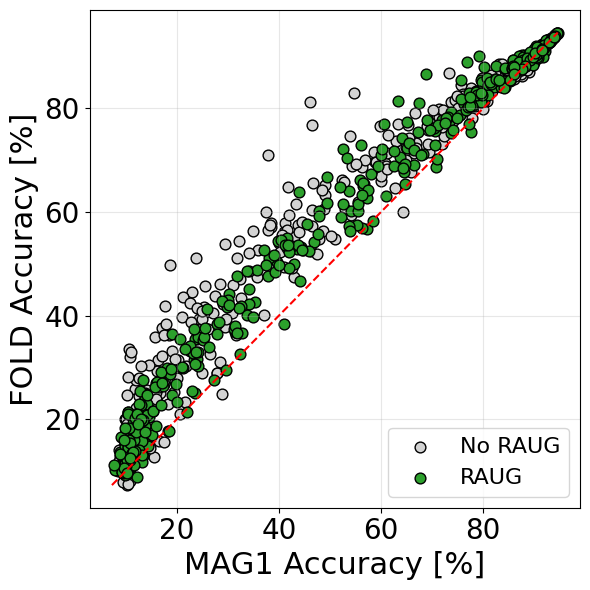

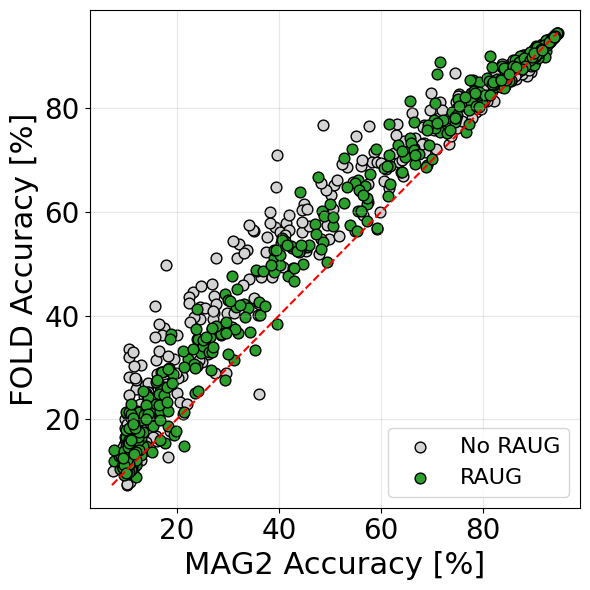

In [138]:
def plot_raug_scatter(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})

    merged_df = pd.merge(
        y_df[["model", "ratio", "acc_y"]],
        x_df [["model", "ratio", "acc_x"]],
        on=["model", "ratio"], how="inner"
    )

    # Ensure needed columns exist by parsing from model name
    to_num = lambda s: pd.to_numeric(s, errors="coerce")
    merged_df["l1"]      = to_num(merged_df["model"].str.extract(r"l1=([0-9.eE+\-]+)", expand=False))
    merged_df["wd"]      = to_num(merged_df["model"].str.extract(r"wd=([0-9.eE+\-]+)", expand=False)).fillna(0.0)
    merged_df["sam_rho"] = to_num(merged_df["model"].str.extract(r"sam_rho=([0-9.eE+\-]+)", expand=False)).fillna(0.0)
    merged_df["raug"]    = merged_df["model"].str.extract(r"(?i)rand_aug=(True|False)", expand=False)\
                                              .map({"True": True, "False": False}).fillna(False)

    # Filter (WD==0.0, desired L1s)
    subset_df = merged_df[merged_df["l1"].isin([0.0]) & np.isclose(merged_df["wd"], 0.0)].copy()

    # Global limits for consistent diagonal
    lo = subset_df[["acc_x", "acc_y"]].min().min()
    hi = subset_df[["acc_x", "acc_y"]].max().max()

    # Plot RAUG vs no-RAUG
    fig, ax = plt.subplots(figsize=(6, 6))
    df = subset_df

    no_raug = df[~df["raug"]]
    yes_raug = df[df["raug"]]

    ax.scatter(no_raug["acc_x"], no_raug["acc_y"],
               c="lightgrey", edgecolor="black", marker="o", s=60, label="No RAUG")
    if not yes_raug.empty:
        ax.scatter(yes_raug["acc_x"], yes_raug["acc_y"],
                   c="tab:green", edgecolor="black", marker="o", s=60, label="RAUG")

    ax.plot([lo, hi], [lo, hi], "r--", label=None)
    ax.set_xlabel(f"{x_name} Accuracy [%]", fontsize=22)
    ax.set_ylabel(f"{y_name} Accuracy [%]", fontsize=22)
    ax.tick_params(axis="both", labelsize=20)
    ax.legend(fontsize=16, loc="lower right")
    ax.grid(True, alpha=0.3)

    fig.tight_layout()
    fig.savefig(f"{opt_name}__raug_scatter__{x_name}_vs_{y_name}.png", dpi=100)
    plt.show()


fold_df  = extract_data(fold_text, include={"l1": 0.0})
mag1_df = extract_data(mag1_text, include={"l1": 0.0})
mag2_df = extract_data(mag2_text, include={"l1": 0.0})

plot_raug_scatter(mag1_df, fold_df, "MAG1", "FOLD")
plot_raug_scatter(mag2_df, fold_df, "MAG2", "FOLD")


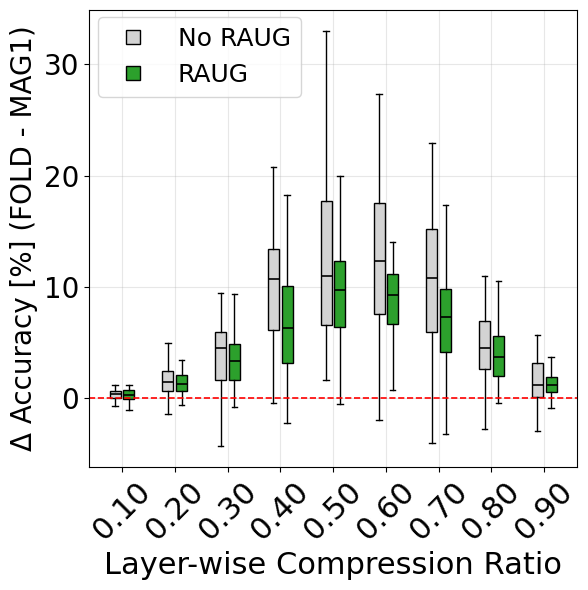

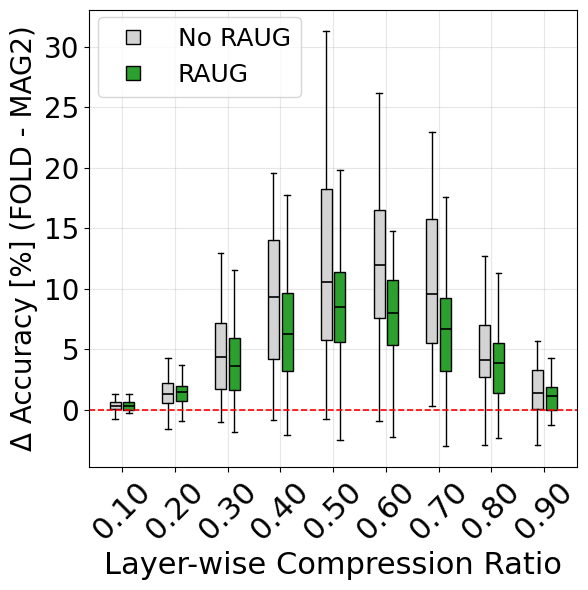

In [139]:
def plot_raug_hist(x_df, y_df, x_name, y_name):
    # helper for grouped x positions (group = RAUG flag within each ratio)
    def grouped_positions(x_vals, n_groups, width=0.22):
        offsets = np.linspace(-((n_groups-1)/2)*width, ((n_groups-1)/2)*width, n_groups)
        return {gi: (np.asarray(x_vals) + offsets[gi]) for gi in range(n_groups)}, width

    # RAUG groups (order, label, color)
    raug_groups = [
        (False, "No RAUG", "lightgray"),
        (True,  "RAUG",    "tab:green"),
    ]

    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})

    merged_df = pd.merge(
        y_df[["model", "ratio", "acc_y"]],
        x_df [["model", "ratio", "acc_x"]],
        on=["model", "ratio"], how="inner"
    )

    # Ensure needed columns exist by parsing from model name
    to_num = lambda s: pd.to_numeric(s, errors="coerce")
    merged_df["l1"]      = to_num(merged_df["model"].str.extract(r"l1=([0-9.eE+\-]+)", expand=False))
    merged_df["wd"]      = to_num(merged_df["model"].str.extract(r"wd=([0-9.eE+\-]+)", expand=False)).fillna(0.0)
    merged_df["raug"]    = merged_df["model"].str.extract(r"(?i)rand_aug=(True|False)", expand=False)\
                                             .map({"True": True, "False": False}).fillna(False)

    # Filter (WD==0.0, desired L1s)
    subset_df = merged_df[merged_df["l1"].isin([0.0]) & np.isclose(merged_df["wd"], 0.0)].copy()

    # Δ accuracy = FOLD − method (positive = FOLD better)
    subset_df["diff"] = subset_df["acc_y"] - subset_df["acc_x"]

    fig, ax = plt.subplots(figsize=(6, 6))
    all_ratios = sorted(subset_df["ratio"].unique())[1:]

    df = subset_df

    x = np.arange(len(all_ratios), dtype=float)
    n_groups = len(raug_groups)
    pos_map, box_w = grouped_positions(x, n_groups, width=0.26)

    # Boxplots per (ratio, RAUG)
    for gi, (raug_flag, raug_label, color) in enumerate(raug_groups):
        pos = pos_map[gi]
        data_for_boxes, valid_pos = [], []
        for r_i, r in enumerate(all_ratios):
            vals = df[(df["ratio"] == r) & (df["raug"] == raug_flag)]["diff"].tolist()
            if vals:
                data_for_boxes.append(vals)
                valid_pos.append(pos[r_i])
        if data_for_boxes:
            bp = ax.boxplot(
                data_for_boxes,
                positions=valid_pos,
                widths=box_w*0.8,
                patch_artist=True,
                showfliers=False
                )
        # style
        for patch in bp["boxes"]:
            patch.set(facecolor=color, alpha=1.0, edgecolor="black")
        for whisk in bp["whiskers"]:
            whisk.set(color="black", linewidth=1)
        for cap in bp["caps"]:
            cap.set(color="black", linewidth=1)
        for median in bp["medians"]:
            median.set(color="black", linewidth=1.2)

    # Aesthetics
    ax.set_xlabel("Layer-wise Compression Ratio", fontsize=22)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{r:.2f}" if isinstance(r, float) else str(r) for r in all_ratios], rotation=45, fontsize=22)
    ax.axhline(0.0, color="red", linestyle="--", linewidth=1.2)  # accuracy gain = 0
    ax.tick_params(axis="y", labelsize=20)
    ax.grid(True, alpha=0.3)

    ax.set_ylabel(f"Δ Accuracy [%] ({y_name} - {x_name})", fontsize=20)

    # Legend
    legend_handles = [
        plt.Line2D([0], [0], marker='s', color='w', label=label,
                   markerfacecolor=color, markeredgecolor='black', markersize=10)
        for _, label, color in raug_groups
    ]
    # fig.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(0.18, 0.985), fontsize=18)
    fig.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(0.15, 0.985), fontsize=18)

    fig.tight_layout()
    fig.savefig(f"{opt_name}__raug_hist__{x_name}_vs_{y_name}.png", dpi=100)
    plt.show()


fold_df  = extract_data(fold_text, include={"l1": 0.0})
mag1_df = extract_data(mag1_text, include={"l1": 0.0})
mag2_df = extract_data(mag2_text, include={"l1": 0.0})

plot_raug_hist(mag1_df, fold_df, "MAG1", "FOLD")
plot_raug_hist(mag2_df, fold_df, "MAG2", "FOLD")

In [140]:
def format_wd_label(wd, tol=1e-12):
    if wd is None or np.isnan(wd) or wd <= 0:
        return "WD=?"
    # power-of-ten?
    exp_rounded = int(round(np.log10(wd)))
    if np.isclose(wd, 10**exp_rounded, rtol=0, atol=tol):
        return rf"WD=$10^{{{exp_rounded}}}$"
    # general scientific form m × 10^n
    exp = int(np.floor(np.log10(wd)))
    mant = wd / (10**exp)
    mant_str = f"{mant:.0f}" if np.isclose(mant, round(mant), atol=tol) else f"{mant:.2g}"
    return rf"WD=${mant_str}\times 10^{{{exp}}}$"

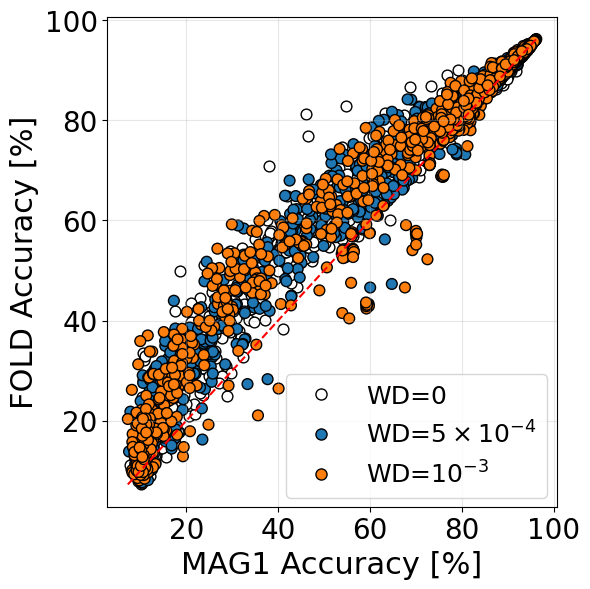

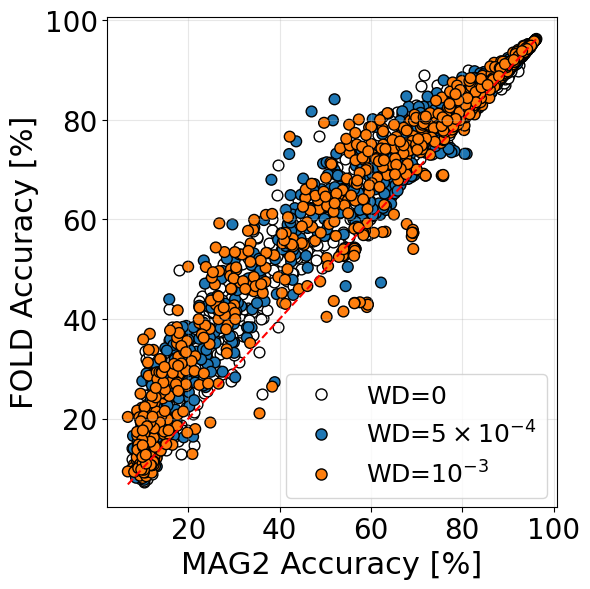

In [141]:
def _parse(name, key, default=np.nan):
    m = re.search(rf"{key}=([0-9.eE+\-]+)", name)
    return float(m.group(1)) if m else default

def _discrete_colors(n):
    # tab10 up to 10, tab20 up to 20, else HSV spread
    if n <= 10:
        cm = colormaps["tab10"]
        return [cm(i) for i in range(n)]
    if n <= 20:
        cm = colormaps["tab20"]
        return [cm(i) for i in range(n)]
    cm = colormaps["hsv"]
    return [cm(i / n) for i in range(n)]


def plot_wd_scatter(x_df, y_df, x_name, y_name):
    eps = 1e-12  # tolerance for "zero"

    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})

    merged = pd.merge(
        y_df[["model", "ratio", "acc_y"]],
        x_df [["model", "ratio", "acc_x"]],
        on=["model", "ratio"], how="inner"
    )

    # ensure l1/wd are numeric (parse from filename)
    merged["l1"] = pd.to_numeric(merged["model"].map(lambda s: _parse(s, "l1")), errors="coerce")
    merged["wd"] = pd.to_numeric(merged["model"].map(lambda s: _parse(s, "wd", 0.0)), errors="coerce").fillna(0.0)

    subset = merged[merged["l1"].isin([0.0])].copy()

    # globals for consistent diagonal
    lo = subset[["acc_x","acc_y"]].min().min()
    hi = subset[["acc_x","acc_y"]].max().max()

    # build discrete palette for all *non-zero* wd values
    wd_levels = sorted([v for v in subset["wd"].unique() if not np.isclose(v, 0.0, atol=eps)])
    wd_colors = _discrete_colors(len(wd_levels))
    wd_to_color = {w: c for w, c in zip(wd_levels, wd_colors)}

    # legend handles (wd=0 plus each non-zero level)
    handles = [plt.Line2D([0],[0], marker='o', linestyle='None', markerfacecolor='white',
                          markeredgecolor='black', label="WD=0", markersize=8)]
    handles += [
        plt.Line2D([0],[0], marker='o', linestyle='None', markerfacecolor=wd_to_color[w],
                   markeredgecolor='black', label=format_wd_label(w), markersize=8)
        for w in wd_levels
    ]

    fig, ax = plt.subplots(figsize=(6, 6))
    df = subset

    # wd == 0 → white
    zero = df[np.isclose(df["wd"], 0.0, atol=eps)]
    if not zero.empty:
        ax.scatter(zero["acc_x"], zero["acc_y"], c="white", edgecolor="black", marker="o", s=60)

    # each non-zero wd gets its own discrete color
    nonz = df[~np.isclose(df["wd"], 0.0, atol=eps)]
    for w in wd_levels:
        g = nonz[np.isclose(nonz["wd"], w, atol=eps)]
        if not g.empty:
            ax.scatter(g["acc_x"], g["acc_y"],
                       c=[wd_to_color[w]] * len(g), edgecolor="black", marker="o", s=60)

    ax.plot([lo, hi], [lo, hi], "r--")
    ax.set_xlabel(f"{x_name} Accuracy [%]", fontsize=22)
    ax.set_ylabel(f"{y_name} Accuracy [%]", fontsize=22)
    ax.tick_params(axis="both", labelsize=20)
    ax.grid(True, alpha=0.3)

    # one shared legend
    # fig.legend(handles=handles, loc="lower right", bbox_to_anchor=(0.98, 0.14), fontsize=18)
    fig.legend(handles=handles, loc="lower right", bbox_to_anchor=(0.94, 0.14), fontsize=18)

    # save + show
    plt.tight_layout()
    fig.savefig(f"{opt_name}__wd_scatter__{x_name}_vs_{y_name}.png", dpi=100)
    plt.show()


fold_df  = extract_data(fold_text, include={"l1": 0.0})
mag1_df = extract_data(mag1_text, include={"l1": 0.0})
mag2_df = extract_data(mag2_text, include={"l1": 0.0})

plot_wd_scatter(mag1_df, fold_df, "MAG1", "FOLD")
plot_wd_scatter(mag2_df, fold_df, "MAG2", "FOLD")


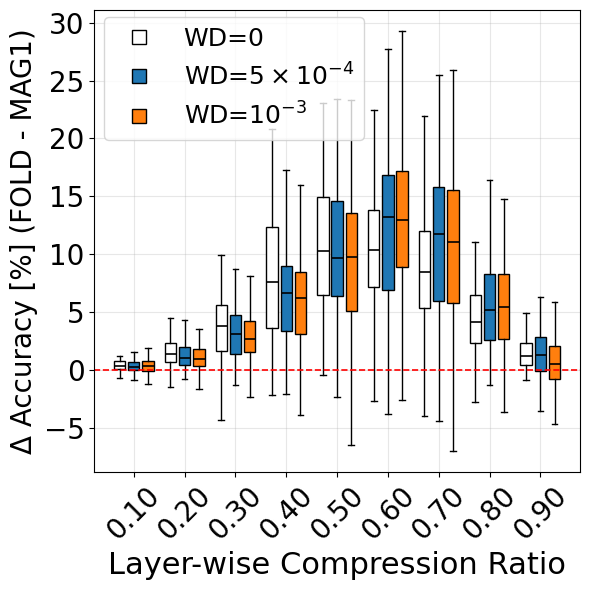

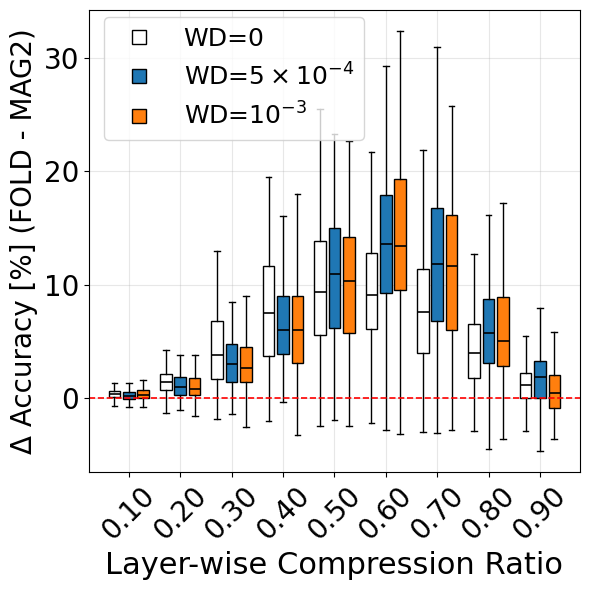

In [142]:
def _parse(name, key, default=np.nan):
    m = re.search(rf"{key}=([0-9.eE+\-]+)", name)
    return float(m.group(1)) if m else default

def _discrete_colors(n):
    # tab10 up to 10, tab20 up to 20, else HSV spread
    if n <= 10:
        cm = colormaps["tab10"]
        return [cm(i) for i in range(n)]
    if n <= 20:
        cm = colormaps["tab20"]
        return [cm(i) for i in range(n)]
    cm = colormaps["hsv"]
    return [cm(i / n) for i in range(n)]

# helper for grouped x positions (group = wd level within each ratio)
def grouped_positions(x_vals, n_groups, width=0.22):
    offsets = np.linspace(-((n_groups-1)/2)*width, ((n_groups-1)/2)*width, n_groups)
    return {gi: (np.asarray(x_vals) + offsets[gi]) for gi in range(n_groups)}, width


def plot_wd_hist(x_df, y_df, x_name, y_name):
    eps = 1e-12  # tolerance for "zero"

    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})

    merged = pd.merge(
        y_df[["model", "ratio", "acc_y"]],
        x_df [["model", "ratio", "acc_x"]],
        on=["model", "ratio"], how="inner"
    )

    # Parse needed hparams
    merged["l1"] = pd.to_numeric(merged["model"].map(lambda s: _parse(s, "l1")), errors="coerce")
    merged["wd"] = pd.to_numeric(merged["model"].map(lambda s: _parse(s, "wd", 0.0)), errors="coerce").fillna(0.0)

    # Filter by L1 (keep all WD levels)
    subset = merged[merged["l1"].isin([0.0])].copy()

    # Δ accuracy (FOLD − method); positive means FOLD is better
    subset["diff"] = subset["acc_y"] - subset["acc_x"]

    # Ratios & WD groups
    all_ratios = sorted(subset["ratio"].unique())
    all_ratios = all_ratios[1:]
    wd_levels_nz = sorted([v for v in subset["wd"].unique() if not np.isclose(v, 0.0, atol=eps)])
    wd_levels_all = [0.0] + wd_levels_nz  # put zero first

    # Colors: wd=0 → white; each non-zero wd gets discrete color
    wd_colors_nz = _discrete_colors(len(wd_levels_nz))
    wd_to_color = {0.0: "white", **{w: c for w, c in zip(wd_levels_nz, wd_colors_nz)}}

    # Figure split by L1
    fig, ax = plt.subplots(figsize=(6, 6))

    df = subset

    x = np.arange(len(all_ratios), dtype=float)
    n_groups = len(wd_levels_all)
    pos_map, box_w = grouped_positions(x, n_groups, width=0.28)

    # Boxplots per (ratio, wd)
    for gi, w in enumerate(wd_levels_all):
        pos = pos_map[gi]
        data_for_boxes, valid_pos = [], []
        for r_i, r in enumerate(all_ratios):
            vals = df[(df["ratio"] == r) & (np.isclose(df["wd"], w, atol=eps))]["diff"].tolist()
            if vals:
                data_for_boxes.append(vals)
                valid_pos.append(pos[r_i])

        if data_for_boxes:
            bp = ax.boxplot(
                data_for_boxes,
                positions=valid_pos,
                widths=box_w*0.8,
                patch_artist=True,
                showfliers=False
            )
            # style
            for patch in bp["boxes"]:
                patch.set(facecolor=wd_to_color[w], alpha=1.0, edgecolor="black")
            for whisk in bp["whiskers"]:
                whisk.set(color="black", linewidth=1)
            for cap in bp["caps"]:
                cap.set(color="black", linewidth=1)
            for median in bp["medians"]:
                median.set(color="black", linewidth=1.2)

    # Aesthetics
    ax.set_xlabel("Layer-wise Compression Ratio", fontsize=22)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{r:.2f}" if isinstance(r, float) else str(r) for r in all_ratios], rotation=45, fontsize=20)
    ax.axhline(0.0, color="red", linestyle="--", linewidth=1.2)  # accuracy gain = 0
    ax.tick_params(axis="y", labelsize=20)
    ax.grid(True, alpha=0.3)

    ax.set_ylabel(f"Δ Accuracy [%] ({y_name} - {x_name})", fontsize=20)

    # Shared legend (wd = 0 plus each non-zero level)
    handles = [plt.Line2D([0],[0], marker='s', linestyle='None', markerfacecolor='white',
                          markeredgecolor='black', label="WD=0", markersize=10)]
    handles += [
        plt.Line2D([0],[0], marker='s', linestyle='None', markerfacecolor=wd_to_color[w],
                   markeredgecolor='black', label=format_wd_label(w), markersize=10)
        for w in wd_levels_nz
    ]
    # fig.legend(handles=handles, loc="upper left", bbox_to_anchor=(0.185, 0.985), fontsize=18)
    fig.legend(handles=handles, loc="upper left", bbox_to_anchor=(0.16, 0.985), fontsize=18)

    plt.tight_layout()
    fig.savefig(f"{opt_name}__wd_hist__{x_name}_vs_{y_name}.png", dpi=100)
    plt.show()


fold_df  = extract_data(fold_text, include={"l1": 0.0})
mag1_df = extract_data(mag1_text, include={"l1": 0.0})
mag2_df = extract_data(mag2_text, include={"l1": 0.0})

plot_wd_hist(mag1_df, fold_df, "MAG1", "FOLD")
plot_wd_hist(mag2_df, fold_df, "MAG2", "FOLD")

#Full Fine-tuning

In [143]:
# Load text content
with open(f"{opt_name}-fold", "r") as f:
    fold_text = f.read()
with open(f"{opt_name}-mag-l1", "r") as f:
    mag1_text = f.read()
with open(f"{opt_name}-mag-l2", "r") as f:
    mag2_text = f.read()

/tmp/ipython-input-1635290762.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


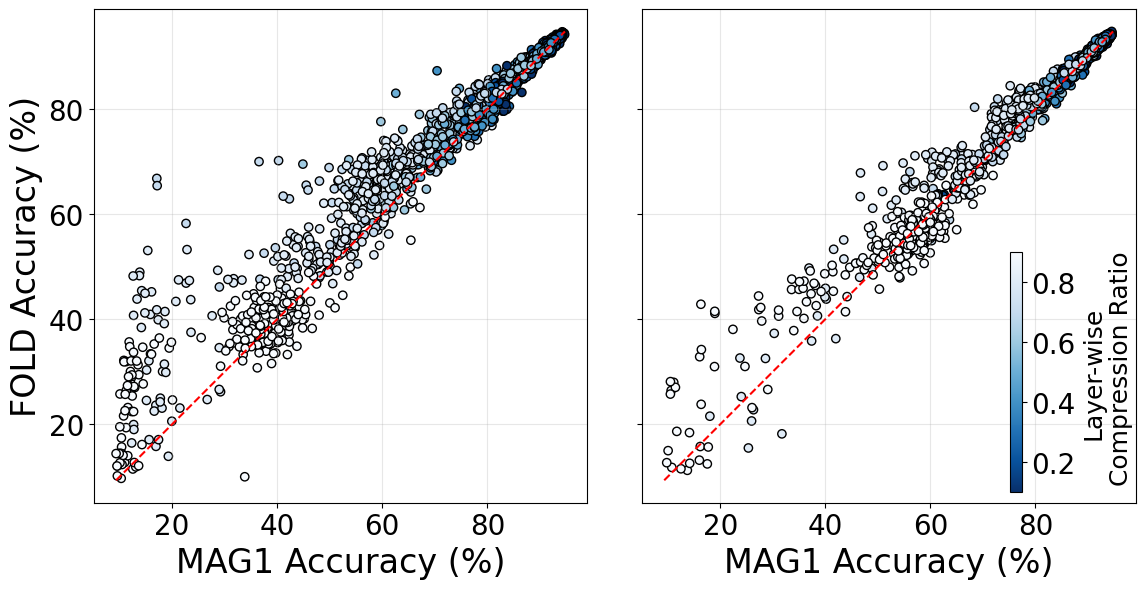

/tmp/ipython-input-1635290762.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


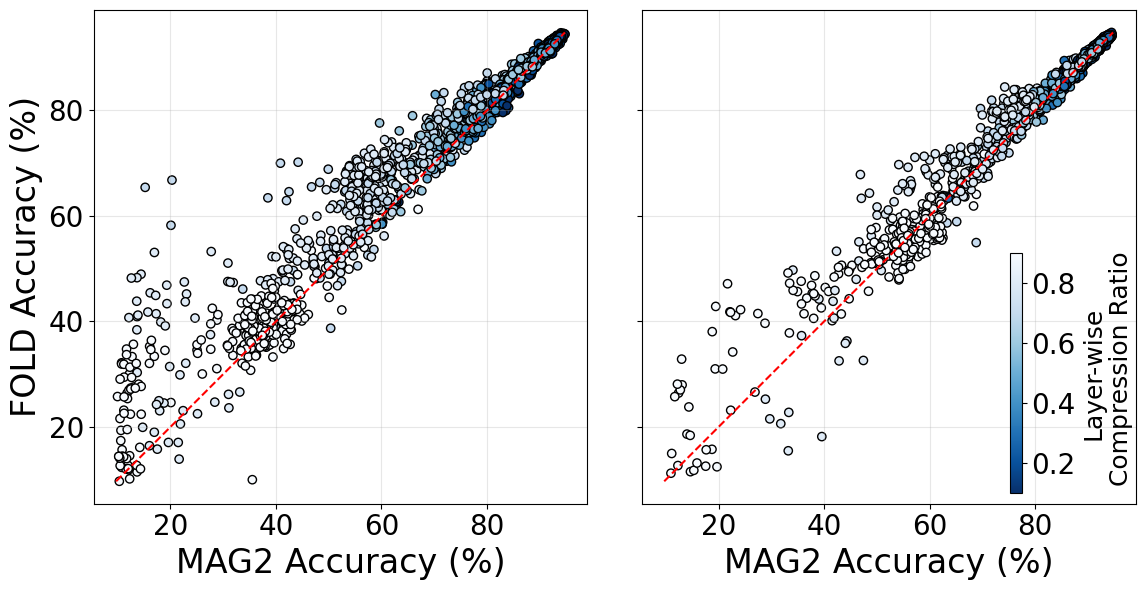

In [144]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# ---- Parse FINETUNE_EPOCH accuracies, using the new extractor for filtering (optional) ----
def parse_epoch_acc_with_extractor(text, include=None, exclude=None):
    """
    Returns: DataFrame with columns [model_id, model, ratio (printed), epoch, acc]
    Uses extract_data(text, include=..., exclude=...) only to choose which [MODEL] blocks to keep.
    """
    keep = extract_data(text, include=include, exclude=exclude)
    keep_models = set(keep["model"].unique()) if not keep.empty else set()

    rows = []
    block_re = re.compile(r"\[MODEL\]\s+(\d+)/\d+\s+(.*?)\.pth(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    for mid, name, block in block_re.findall(text):
        mid = int(mid); name = name.strip()
        if keep_models and name not in keep_models:
            continue

        for r, ep, acc in re.findall(r"RATIO=([\d.]+)\s+EVENT=FINETUNE_EPOCH(\d+)\s+acc=([\d.]+)", block):
            rows.append({
                "model_id": mid,
                "model": name,
                "ratio": float(r),          # keep printed RATIO (do not remap)
                "epoch": int(ep),
                "acc": float(acc),
            })
    return pd.DataFrame(rows)

# -------- Extract data (rename acc columns) --------
fold_df = parse_epoch_acc_with_extractor(fold_text, include={"l1": 0.0}).rename(columns={"acc": "acc_fold"})
mag_l1_df = parse_epoch_acc_with_extractor(mag1_text, include={"l1": 0.0}).rename(columns={"acc": "acc"})
mag_l2_df = parse_epoch_acc_with_extractor(mag2_text, include={"l1": 0.0}).rename(columns={"acc": "acc"})

for method_name, method_df in zip(["MAG1","MAG2"], [mag_l1_df, mag_l2_df]):
    # Keep epochs 1 and 5
    epochs_to_show = [1, 5]
    fold_df = fold_df[fold_df["epoch"].isin(epochs_to_show)]
    method_df = method_df[method_df["epoch"].isin(epochs_to_show)]

    # Merge by model_id, model, ratio, epoch
    merged = pd.merge(
        fold_df, method_df,
        on=["model_id", "model", "ratio", "epoch"],
        how="inner"
    )

    # ---- Plot (keep your font sizes & style) ----
    if merged.empty:
        print("No overlapping FINETUNE_EPOCH entries to plot.")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

        cmap = cm.Blues_r
        norm = mcolors.Normalize(vmin=merged["ratio"].min(), vmax=merged["ratio"].max())

        # common limits across both panels to keep the y=x diagonal comparable
        global_lo = merged[["acc", "acc_fold"]].min().min()
        global_hi = merged[["acc", "acc_fold"]].max().max()

        for i, ep in enumerate(epochs_to_show):
            ax = axes[i]
            data = merged[merged["epoch"] == ep]
            if data.empty:
                ax.set_visible(False)
                continue

            ax.scatter(
                data["acc"], data["acc_fold"],
                c=cmap(norm(data["ratio"].values)),
                edgecolors="black"
            )

            # Diagonal y = x
            ax.plot([global_lo, global_hi], [global_lo, global_hi], 'r--', alpha=1.0)

            # Labels & style (keep your sizes)
            # ax.set_title(f"Fine-tune Epoch {ep}", fontsize=24)
            ax.set_xlabel(f"{method_name} Accuracy (%)", fontsize=24)
            if i == 0:
                ax.set_ylabel("FOLD Accuracy (%)", fontsize=24)

            ax.set_aspect('equal', adjustable='box')
            ax.tick_params(axis='both', which='major', labelsize=20)
            ax.grid(True, alpha=0.3)

        plt.tight_layout()

        # Shared colorbar (no manual cax → no tight_layout warning)
        sm = cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        cax = fig.add_axes([0.86, 0.17, 0.01, 0.4])
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
        cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
        cbar.ax.tick_params(labelsize=20)

        fig.tight_layout()
        fig.savefig(f"{opt_name}__fold_vs_{method_name}_after_ft.png", dpi=100)
        plt.show()


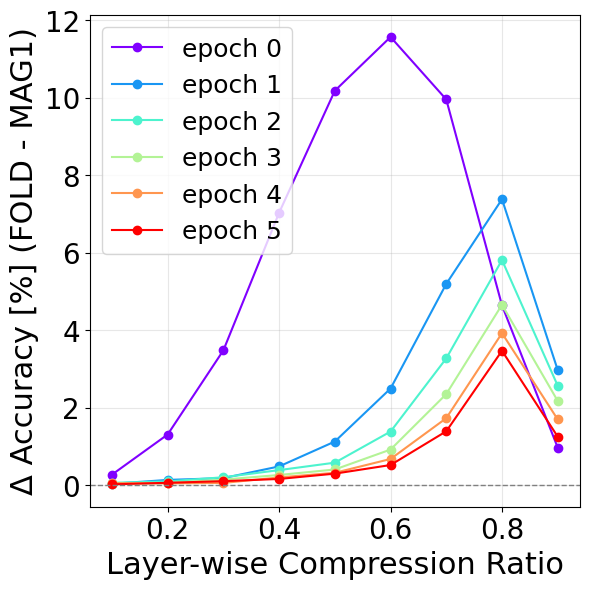

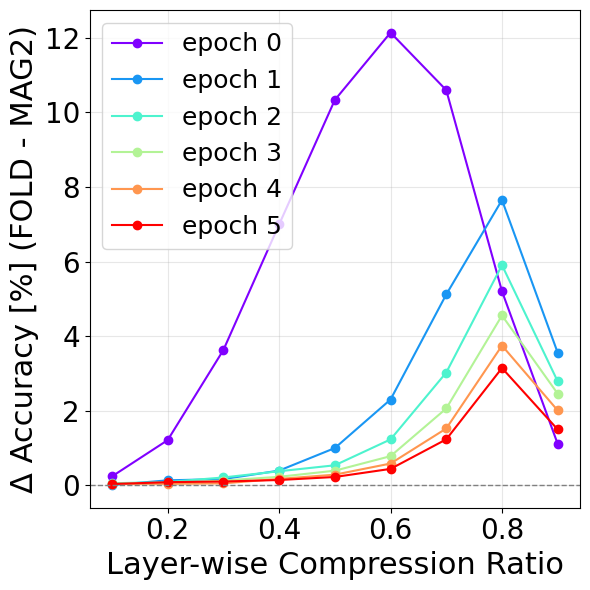

In [145]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- Parse REPAIR (epoch 0) and FINETUNE_EPOCHx (epochs 1..5) using the new extractor for filtering ---
def parse_epoch_acc_with_extractor(text, include=None, exclude=None):
    """
    Returns: DataFrame[model_id, model, ratio (printed), epoch, test_acc]
    - Uses extract_data(text, include=..., exclude=...) ONLY to choose which [MODEL] blocks to keep.
    - Pairs each REPAIR / FINETUNE_EPOCH line with its own printed RATIO directly (no stateful carryover).
    """
    keep = extract_data(text, include=include, exclude=exclude)
    keep_models = set(keep["model"].unique()) if not keep.empty else set()

    rows = []
    block_re = re.compile(r"\[MODEL\]\s+(\d+)/\d+\s+(.*?)\.pth(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    for mid, name, block in block_re.findall(text):
        mid = int(mid); name = name.strip()
        if keep_models and name not in keep_models:
            continue

        # REPAIR (epoch 0): ratio and acc on the SAME line
        for r, acc in re.findall(r"RATIO=([0-9.]+)\s+EVENT=REPAIR\s+acc=([0-9.]+)", block):
            rows.append((mid, name, float(r), int(0), float(acc)))

        # FINETUNE_EPOCHk: ratio and acc on the SAME line
        for r, ep, acc in re.findall(r"RATIO=([0-9.]+)\s+EVENT=FINETUNE_EPOCH(\d+)\s+acc=([0-9.]+)", block):
            rows.append((mid, name, float(r), int(ep), float(acc)))

    return pd.DataFrame(rows, columns=["model_id", "model", "ratio", "epoch", "test_acc"])


# -------- Extract for both methods (add include/exclude filters if you want) --------
fold_df = parse_epoch_acc_with_extractor(fold_text, include={"l1": 0.0}).rename(columns={"test_acc": "acc_fold"})
mag1_df = parse_epoch_acc_with_extractor(mag1_text, include={"l1": 0.0}).rename(columns={"test_acc": "acc"})
mag2_df = parse_epoch_acc_with_extractor(mag2_text, include={"l1": 0.0}).rename(columns={"test_acc": "acc"})

for method_name, method_df in zip(["MAG1","MAG2"], [mag1_df, mag2_df]):
    # Merge on model identity + ratio + epoch (model_id alone can collide across logs)

    merged = pd.merge(
        fold_df, method_df,
        on=["model", "ratio", "epoch"],
        how="inner"
    )

    if merged.empty:
        print("No overlapping REPAIR/FINETUNE entries between FOLD and MAG-L1.")
    else:
        # Relative gain: FOLD - MAG-L1 (same style as your original)
        merged["rel_gain"] = merged["acc_fold"] - merged["acc"]

        # Mean gain per pruning ratio and epoch
        mean_gain = (merged.groupby(["ratio", "epoch"])["rel_gain"]
                            .mean()
                            .reset_index()
                            .sort_values(["epoch", "ratio"]))

        # ---- Plot (keep your style & font sizes) ----
        fig, ax = plt.subplots(figsize=(6, 6))
        epochs = sorted(mean_gain["epoch"].unique())
        colors = cm.rainbow(np.linspace(0, 1, len(epochs)))

        for ep, c in zip(epochs, colors):
            d = mean_gain[mean_gain["epoch"] == ep]
            ax.plot(d["ratio"], d["rel_gain"], "o-", color=c, label=f"epoch {ep}")

        ax.axhline(0, color="gray", ls="--", lw=1)
        ax.set_xlabel("Layer-wise Compression Ratio", fontsize=22)
        ax.set_ylabel(f"Δ Accuracy [%] (FOLD - {method_name})", fontsize=22)
        ax.tick_params(labelsize=20)
        ax.legend(fontsize=18)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        fig.savefig(f"{opt_name}__fold_vs_{method_name}_after_ft_gain.png", dpi=100)
        plt.show()


/tmp/ipython-input-3652706868.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


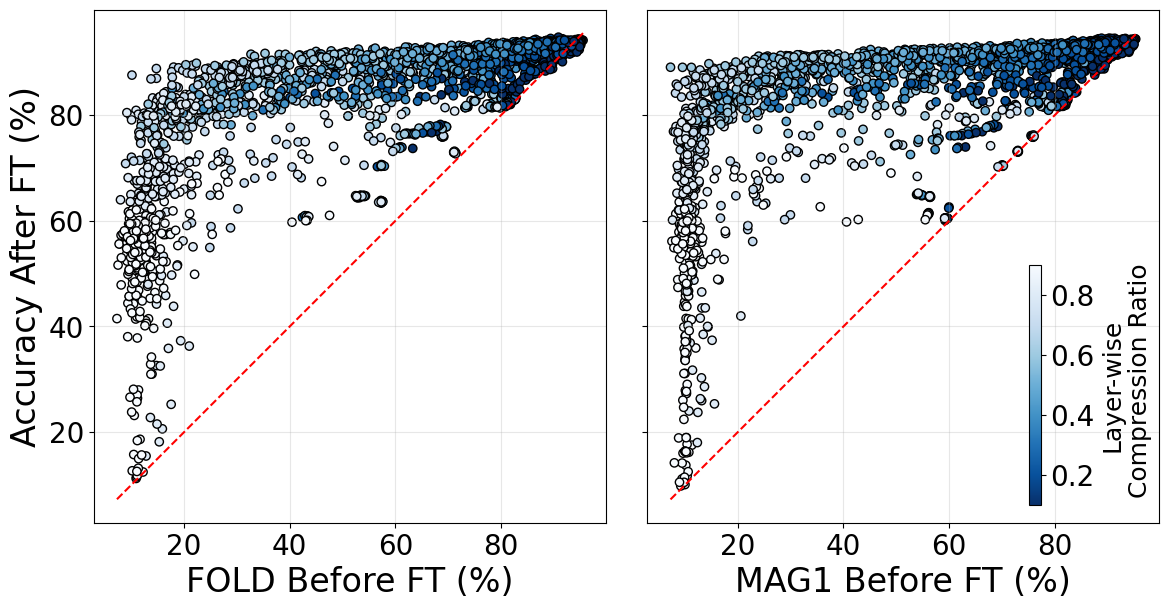

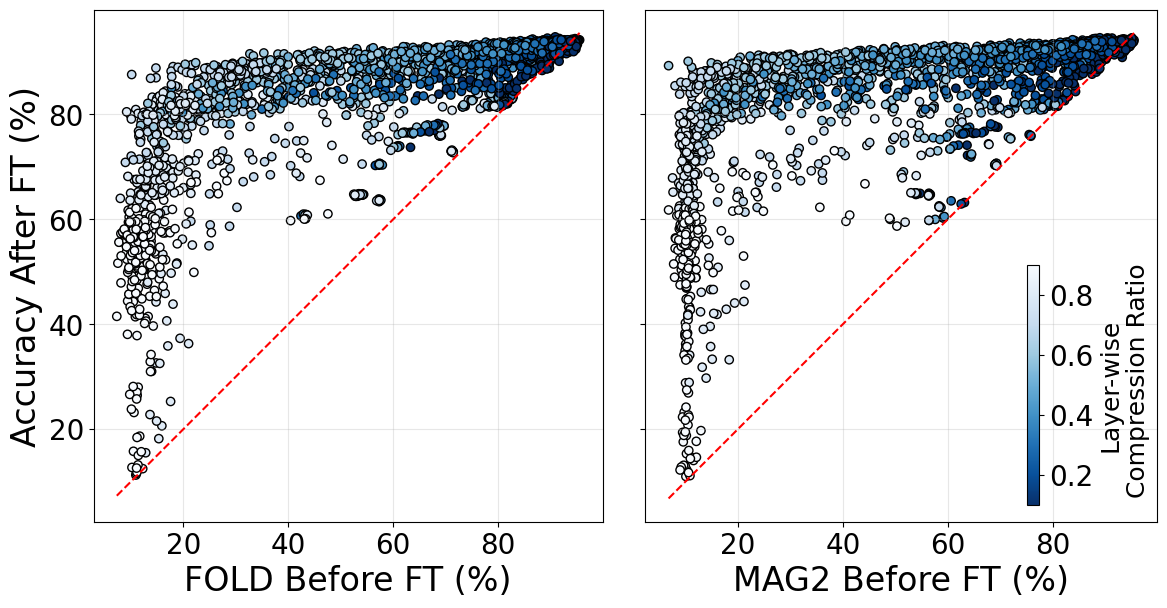

In [146]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# --- Before/After FT5 using the unified extractor for filtering ---
def extract_before_after_ft(text, include=None, exclude=None):
    """
    Return DataFrame: model_id | model | ratio (printed) | before_acc (REPAIR) | after_acc (FINETUNE_EPOCH5)
    Uses `extract_data(text, include=..., exclude=...)` ONLY to decide which [MODEL] blocks to keep.
    """
    keep = extract_data(text, include=include, exclude=exclude)
    keep_models = set(keep["model"].unique()) if not keep.empty else set()

    rows = []
    block_re = re.compile(r"\[MODEL\]\s+(\d+)/\d+\s+(.*?)\.pth(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    for mid, name, block in block_re.findall(text):
        mid = int(mid); name = name.strip()
        if keep_models and name not in keep_models:
            continue

        # collect REPAIR and FT5 per printed ratio
        repairs = {float(r): float(a) for r, a in re.findall(
            r"RATIO=([0-9.]+)\s+EVENT=REPAIR\s+acc=([0-9.]+)", block)}
        ft5 = {float(r): float(a) for r, a in re.findall(
            r"RATIO=([0-9.]+)\s+EVENT=FINETUNE_EPOCH5\s+acc=([0-9.]+)", block)}

        for r in sorted(set(repairs) & set(ft5)):
            rows.append((mid, name, r, repairs[r], ft5[r]))

    return pd.DataFrame(rows, columns=["model_id", "model", "ratio", "before_acc", "after_acc"])


# --- Load logs (filter via include/exclude if desired) ---
fold_df = extract_before_after_ft(fold_text, include={"l1": 0.0})
mag1_df = extract_before_after_ft(mag1_text, include={"l1": 0.0})
mag2_df = extract_before_after_ft(mag2_text, include={"l1": 0.0})

for method_name, method_df in zip(["MAG1","MAG2"], [mag1_df, mag2_df]):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    combined_ratios = pd.concat([d["ratio"] for d in [fold_df, method_df] if not d.empty])
    norm = mcolors.Normalize(vmin=combined_ratios.min(), vmax=combined_ratios.max())
    cmap = cm.Blues_r

    def plot_method(ax, df, name):
        sc = ax.scatter(
            df["before_acc"], df["after_acc"],
            c=cmap(norm(df["ratio"].values)), edgecolors="black"
        )
        lo = min(df["before_acc"].min(), df["after_acc"].min())
        hi = max(df["before_acc"].max(), df["after_acc"].max())
        ax.plot([lo, hi], [lo, hi], 'r--', alpha=1.0)
        ax.set_xlabel(f"{name} Before FT (%)", fontsize=24)
        ax.set_aspect('equal', adjustable='box')
        ax.tick_params(axis='both', labelsize=20)
        return sc

    for ax, tdf, name in zip(axes, [fold_df, method_df], ["FOLD", method_name]):
        if tdf.empty:
            continue
        plot_method(ax, tdf, name)
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Accuracy After FT (%)", fontsize=24)


    # Shared colorbar (attach to axes to avoid tight_layout issues)
    cax = fig.add_axes([0.87, 0.15, 0.01, 0.4])
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
    cbar.ax.tick_params(labelsize=20)

    fig.tight_layout()
    fig.savefig(f"{opt_name}__fold_and_{method_name}_before_and_after_ft.png", dpi=100)
    plt.show()


In [147]:
!zip out.zip *.png

  adding: sgd__compression_ratio_hist__MAG1_vs_FOLD.png (deflated 10%)
  adding: sgd__compression_ratio_hist__MAG2_vs_FOLD.png (deflated 10%)
  adding: sgd__compression_ratio_scatter__MAG1_vs_FOLD.png (deflated 2%)
  adding: sgd__compression_ratio_scatter__MAG2_vs_FOLD.png (deflated 2%)
  adding: sgd__fold_and_MAG1_before_and_after_ft.png (deflated 3%)
  adding: sgd__fold_and_MAG2_before_and_after_ft.png (deflated 3%)
  adding: sgd__fold_vs_MAG1_after_ft_gain.png (deflated 5%)
  adding: sgd__fold_vs_MAG1_after_ft.png (deflated 4%)
  adding: sgd__fold_vs_MAG2_after_ft_gain.png (deflated 4%)
  adding: sgd__fold_vs_MAG2_after_ft.png (deflated 4%)
  adding: sgd__lr_hist__MAG1_vs_FOLD.png (deflated 9%)
  adding: sgd__lr_hist__MAG2_vs_FOLD.png (deflated 10%)
  adding: sgd__lr_scatter__MAG1_vs_FOLD.png (deflated 3%)
  adding: sgd__lr_scatter__MAG2_vs_FOLD.png (deflated 3%)
  adding: sgd__raug_hist__MAG1_vs_FOLD.png (deflated 10%)
  adding: sgd__raug_hist__MAG2_vs_FOLD.png (deflated 10%)
  add